In [1]:
import pandas as pd
import os
from pandas import read_csv
from pandas import read_parquet
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import pyarrow
import fastparquet
from datetime import datetime, timezone, timedelta
import scipy.stats as s

warnings.filterwarnings("ignore")

work_dir = '/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/GEMS/BILD-AQ/data'
os.chdir(work_dir)

selected_state = 'CA'
plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font
meter_to_mile = 0.000621371

In [2]:
# bildaq_od_data = read_csv('Output/' + selected_state+ '/OD_summary_with_routed_distance.csv')
NHTS_od_data = read_csv('Network/' + selected_state+ '/NHTS_car_trips_CA.csv' )
dist_matrix_file = 'distance_matrix_by_tracts.csv'
dist_matrix = pd.read_csv('Network/' + selected_state + '/' + dist_matrix_file, sep = ',')
dist_matrix = dist_matrix.rename(columns = {'Unnamed: 0': 'origin'})
dist_matrix_long = pd.melt(dist_matrix, id_vars = 'origin', 
                        var_name = 'destination', value_name = 'distance')


list_of_inrix_trips = os.listdir('Validation/inrix.trips.20200101.ca')
inrix_trip_out = None
for file in list_of_inrix_trips:
    if file.endswith('.parquet'):
        print(file)
        inrix_trips = read_parquet('Validation/inrix.trips.20200101.ca/' + file, engine = 'auto')
        inrix_trip_out = pd.concat([inrix_trip_out, inrix_trips])
#         break


inrix.trips.20200101.ca.c004.gz.parquet
inrix.trips.20200101.ca.c001.gz.parquet
inrix.trips.20200101.ca.c003.gz.parquet
inrix.trips.20200101.ca.c000.gz.parquet
inrix.trips.20200101.ca.c005.gz.parquet
inrix.trips.20200101.ca.c002.gz.parquet


In [3]:
# format start time
print(len(inrix_trip_out))
inrix_trip_out.loc[:, 'start_date'] = inrix_trip_out.loc[:, 'start_date'].str.split('.').str[0]
inrix_trip_out.loc[:, 'end_date'] = inrix_trip_out.loc[:, 'end_date'].str.split('.').str[0]
# inrix_trip_out.loc[:, 'start_time'] = \
# inrix_trip_out.loc[:, 'start_date'].str.split('T').str[1]
# inrix_trip_out.loc[:, 'start_date'] = \
# inrix_trip_out.loc[:, 'start_date'].str.split('T').str[0]

inrix_trip_out['start_time'] = \
pd.to_datetime(inrix_trip_out['start_date'].astype(str), format='%Y-%m-%dT%H:%M:%S')
inrix_trip_out['start_time'] = inrix_trip_out['start_time'].dt.tz_localize('utc').dt.tz_convert('America/Los_Angeles')

inrix_trip_out['end_time'] = \
pd.to_datetime(inrix_trip_out['end_date'].astype(str), format='%Y-%m-%dT%H:%M:%S')
inrix_trip_out['end_time'] = inrix_trip_out['end_time'].dt.tz_localize('utc').dt.tz_convert('America/Los_Angeles')
inrix_trip_out.loc[:, 'start_hour'] = \
inrix_trip_out.loc[:, 'start_time'].dt.hour
inrix_trip_out.loc[:, 'end_hour'] = \
inrix_trip_out.loc[:, 'end_time'].dt.hour
inrix_trip_out.head(5)


5968815


,trip_id,device_id,provider_id,mode,start_date,start_dow,end_date,end_dow,start_lat,start_lon,...,start_qk,end_qk,start_zcta,start_cbg,end_zcta,end_cbg,start_time,end_time,start_hour,end_hour
0,eacacad470730a08a94912cf4692fb7a,None,d07e70efcfab08731a97e7b91be644de,1,2020-01-01T22:20:54,3,2020-01-01T22:34:11,3,34.11351,-117.76863,...,023013200120202031,023013200130121221,91750,060374016023,91739,060710020213,2020-01-01 14:20:54-08:00,2020-01-01 14:34:11-08:00,14,14
1,ebb5743a9fa805bb71a003612cf82f6b,None,d07e70efcfab08731a97e7b91be644de,1,2020-01-01T04:54:11,2,2020-01-01T05:31:25,2,34.10668,-117.90733,...,023013200030231110,023013200310211321,91722,060374058001,91752,060650406151,2019-12-31 20:54:11-08:00,2019-12-31 21:31:25-08:00,20,21
2,ec96759cc88ae460c4e995f39075260b,None,42998cf32d552343bc8e460416382dca,1,2020-01-01T21:27:30,3,2020-01-01T21:59:10,3,34.07825,-117.56263,...,023013200132013003,023013200131201132,91730,060710021101,92336,060710020371,2020-01-01 13:27:30-08:00,2020-01-01 13:59:10-08:00,13,13
3,ece8ae0d36fe5410de426337c87bfd71,None,42998cf32d552343bc8e460416382dca,1,2020-01-01T18:06:12,3,2020-01-01T18:15:20,3,37.27022,-122.01622,...,023010230231123132,023010230302221232,95070,060855073013,95129,060855062042,2020-01-01 10:06:12-08:00,2020-01-01 10:15:20-08:00,10,10
4,ed7d9fe22cedc2dd0598aba3cf11dc39,None,d07e70efcfab08731a97e7b91be644de,1,2020-01-01T03:09:30,2,2020-01-01T03:13:16,2,36.31678,-119.29161,...,023012110032323330,023012110210100320,93277,061070017014,93277,061070019011,2019-12-31 19:09:30-08:00,2019-12-31 19:13:16-08:00,19,19


In [4]:
# filter trips
print(inrix_trip_out.columns)
inrix_trip_out.loc[:, 'travel_time'] = inrix_trip_out.loc[:, 'end_time'] - inrix_trip_out.loc[:, 'start_time'] 
inrix_trip_out = inrix_trip_out.loc[inrix_trip_out['mode'] == 1] # vehicle
inrix_trip_out = inrix_trip_out.loc[inrix_trip_out['movement_type'] == 1] # moving trips
inrix_trip_out = inrix_trip_out.loc[inrix_trip_out['vehicle_weight_class'] == 1] # LDVs
# inrix_trip_out = inrix_trip_out.loc[inrix_trip_out['provider_type'] != 2] # no fleet vehicles
print(len(inrix_trip_out))

Index(['trip_id', 'device_id', 'provider_id', 'mode', 'start_date',
       'start_dow', 'end_date', 'end_dow', 'start_lat', 'start_lon', 'end_lat',
       'end_lon', 'geospatial_type', 'provider_type', 'driving_profile',
       'vehicle_weight_class', 'probe_source_type', 'dest_zone',
       'endpoint_type', 'trip_mean_speed_kph', 'trip_max_speed_kph',
       'trip_distance_m', 'movement_type', 'start_tz', 'end_tz', 'wp_freq_sec',
       'start_qk', 'end_qk', 'start_zcta', 'start_cbg', 'end_zcta', 'end_cbg',
       'start_time', 'end_time', 'start_hour', 'end_hour'],
      dtype='object')
5687242


In [5]:
meter_to_mile = 0.000621371
avg_trip_dist_hour_inrix = inrix_trip_out.groupby('start_hour')[['trip_distance_m']].mean()
avg_trip_dist_hour_inrix = avg_trip_dist_hour_inrix.reset_index()
avg_trip_dist_hour_inrix.loc[:, 'trip_dist'] = meter_to_mile * avg_trip_dist_hour_inrix.loc[:, 'trip_distance_m']
avg_trip_dist_hour_inrix.head(5)

,start_hour,trip_distance_m,trip_dist
0,0,17841.122871,11.085956
1,1,19203.410102,11.932442
2,2,20696.745466,12.860357
3,3,24413.700490,15.169965
4,4,31466.896377,19.552617


In [7]:
# format NHTS data
# print(NHTS_od_data.columns)
# NHTS_od_data.head(5)
NHTS_od_data.loc[:, 'start hour'] = np.round(NHTS_od_data.loc[:, 'start hour'], 0)
NHTS_od_data.loc[:, 'start hour'] = NHTS_od_data.loc[:, 'start hour'].astype(int)
NHTS_od_data.loc[:, 'total_miles'] = NHTS_od_data.loc[:, 'trpmiles'] * \
NHTS_od_data.loc[:, 'wtperfin']
avg_trip_dist_hour_nhts = NHTS_od_data.groupby(['start hour'])[['total_miles', 'wtperfin']].sum()
avg_trip_dist_hour_nhts = avg_trip_dist_hour_nhts.reset_index()
avg_trip_dist_hour_nhts.loc[:, 'trip_dist'] = avg_trip_dist_hour_nhts.loc[:, 'total_miles'] / avg_trip_dist_hour_nhts.loc[:, 'wtperfin']
avg_trip_dist_hour_nhts.head(5)

,start hour,total_miles,wtperfin,trip_dist
0,0,3.890396e+06,262534.366001,14.818617
1,1,2.355454e+06,144023.559069,16.354646
2,2,2.079132e+06,143864.120468,14.452054
3,3,2.628836e+05,30513.952252,8.615193
4,4,8.688421e+06,333469.709530,26.054602


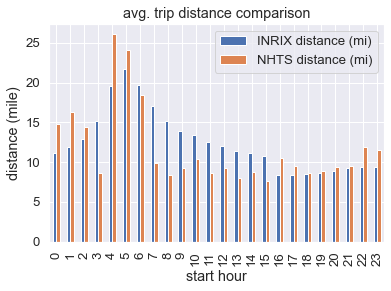

In [9]:
# avg_trip_dist_hour_inrix = avg_trip_dist_hour_inrix[['start_hour',	'trip_dist']]
# avg_trip_dist_hour_nhts = avg_trip_dist_hour_nhts[['start hour', 'trip_dist']]
# avg_trip_dist_hour_inrix.columns = ['start hour', 'INRIX distance (mi)']
# avg_trip_dist_hour_nhts.columns = ['start hour', 'NHTS distance (mi)']

trip_dist_comparison = pd.merge(avg_trip_dist_hour_inrix, avg_trip_dist_hour_nhts,
                                on = 'start hour', how = 'left')
trip_dist_comparison.plot(x = 'start hour', kind = 'bar')
plt.title('avg. trip distance comparison')
plt.ylabel('distance (mile)')
plt.savefig('Plot/trip_distance_comparison_inrix.png')

In [5]:
# assign census tract id to beam data
inrix_trip_out = inrix_trip_out.dropna(subset = ['start_cbg', 'end_cbg'])
inrix_trip_out.loc[:, ['start_cbg', 'end_cbg']] = inrix_trip_out.loc[:, ['start_cbg', 'end_cbg']].astype(int)
inrix_trip_out.loc[:, 'o_GEOID'] = inrix_trip_out.loc[:, 'start_cbg'] / 10
inrix_trip_out.loc[:, 'd_GEOID'] = inrix_trip_out.loc[:, 'end_cbg'] / 10


inrix_trip_out.loc[:, ['o_GEOID', 'd_GEOID']] = inrix_trip_out.loc[:, ['o_GEOID', 'd_GEOID']].astype(int)
print(len(inrix_trip_out))
inrix_trip_out.head(5)                                                            


5664551


,trip_id,device_id,provider_id,mode,start_date,start_dow,end_date,end_dow,start_lat,start_lon,...,start_cbg,end_zcta,end_cbg,start_time,end_time,start_hour,end_hour,travel_time,o_GEOID,d_GEOID
0,eacacad470730a08a94912cf4692fb7a,None,d07e70efcfab08731a97e7b91be644de,1,2020-01-01T22:20:54,3,2020-01-01T22:34:11,3,34.11351,-117.76863,...,60374016023,91739,60710020213,2020-01-01 14:20:54-08:00,2020-01-01 14:34:11-08:00,14,14,0 days 00:13:17,6037401602,6071002021
1,ebb5743a9fa805bb71a003612cf82f6b,None,d07e70efcfab08731a97e7b91be644de,1,2020-01-01T04:54:11,2,2020-01-01T05:31:25,2,34.10668,-117.90733,...,60374058001,91752,60650406151,2019-12-31 20:54:11-08:00,2019-12-31 21:31:25-08:00,20,21,0 days 00:37:14,6037405800,6065040615
2,ec96759cc88ae460c4e995f39075260b,None,42998cf32d552343bc8e460416382dca,1,2020-01-01T21:27:30,3,2020-01-01T21:59:10,3,34.07825,-117.56263,...,60710021101,92336,60710020371,2020-01-01 13:27:30-08:00,2020-01-01 13:59:10-08:00,13,13,0 days 00:31:40,6071002110,6071002037
3,ece8ae0d36fe5410de426337c87bfd71,None,42998cf32d552343bc8e460416382dca,1,2020-01-01T18:06:12,3,2020-01-01T18:15:20,3,37.27022,-122.01622,...,60855073013,95129,60855062042,2020-01-01 10:06:12-08:00,2020-01-01 10:15:20-08:00,10,10,0 days 00:09:08,6085507301,6085506204
4,ed7d9fe22cedc2dd0598aba3cf11dc39,None,d07e70efcfab08731a97e7b91be644de,1,2020-01-01T03:09:30,2,2020-01-01T03:13:16,2,36.31678,-119.29161,...,61070017014,93277,61070019011,2019-12-31 19:09:30-08:00,2019-12-31 19:13:16-08:00,19,19,0 days 00:03:46,6107001701,6107001901


In [6]:
# generate travel time and distance skim
inrix_trip_out.loc[:, 'travel_time_h'] =  inrix_trip_out.loc[:, 'travel_time']/ pd.Timedelta(hours=1)
# inrix_trip_out.loc[:, 'travel_time_h'].head(5)
travel_time_by_od = inrix_trip_out.groupby(['o_GEOID', 'd_GEOID'])[['trip_distance_m', 'travel_time_h']].mean()
travel_time_by_od = travel_time_by_od.reset_index()
travel_time_by_od.loc[:, 'trip_distance_m'] *= meter_to_mile

travel_time_by_od.columns = ['o_GEOID', 'd_GEOID', 'distance_mile', 'travel_time_h']
print(len(travel_time_by_od))
travel_time_by_od.head(5)

1332446


,o_GEOID,d_GEOID,distance_mile,travel_time_h
0,6001400100,6001400100,4.774483,0.267772
1,6001400100,6001400200,1.874526,0.162014
2,6001400100,6001400300,2.133973,0.166736
3,6001400100,6001400400,2.498275,0.169167
4,6001400100,6001400600,2.556458,0.101111


Text(0, 0.5, 'travel time (hour)')

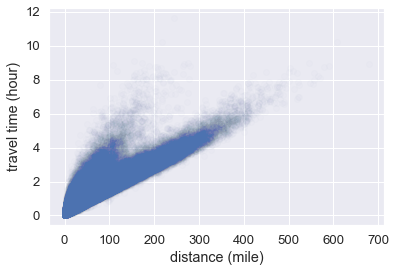

In [9]:
plt.scatter(travel_time_by_od['distance_mile'], 
            travel_time_by_od['travel_time_h'], alpha = 0.01)
plt.xlabel('distance (mile)')
plt.ylabel('travel time (hour)')

<Figure size 864x1152 with 0 Axes>

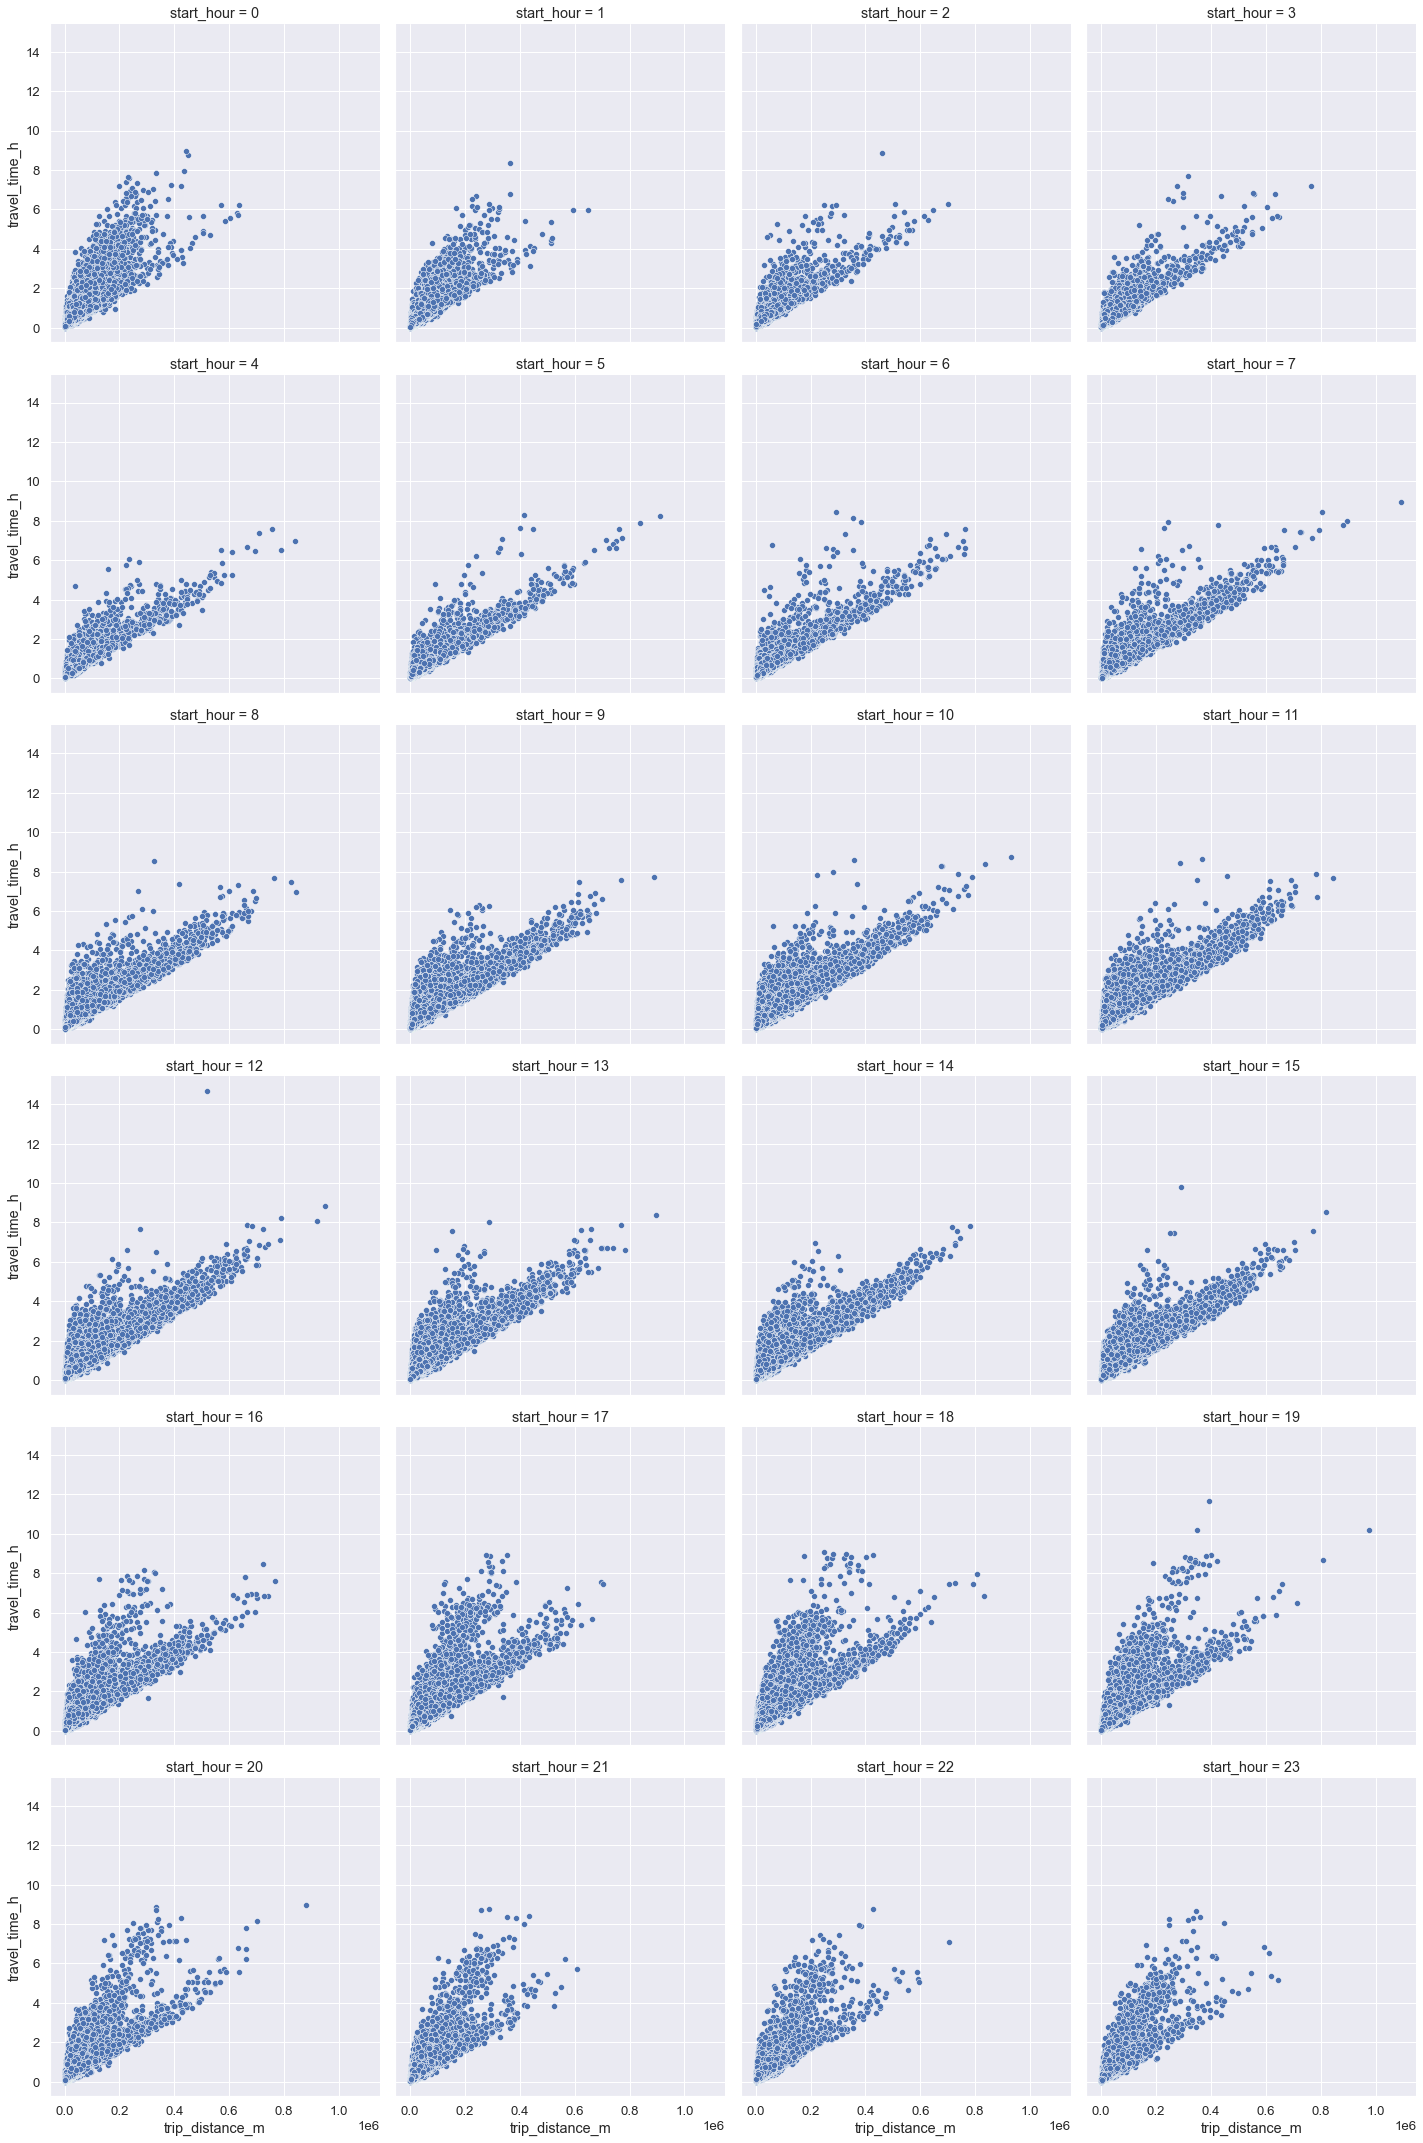

In [17]:
plt.figure(figsize=(12, 16))
sns.relplot(data = inrix_trip_out, 
                x="trip_distance_m",
                y="travel_time_h", col="start_hour", 
            col_wrap = 4,  kind="scatter")
plt.savefig('Plot/' + selected_state+ '/INRIX_trip_time_distance_scatter.png', dpi = 300)

Text(0, 0.5, 'travel time (hour)')

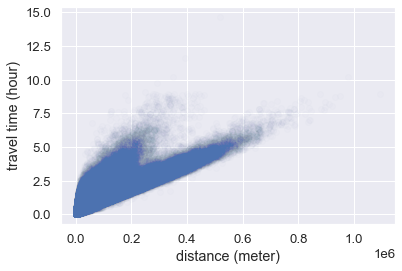

In [24]:
plt.scatter(inrix_trip_out['trip_distance_m'], 
            inrix_trip_out['travel_time_h'], alpha = 0.01)
plt.xlabel('distance (meter)')
plt.ylabel('travel time (hour)')

In [12]:
from scipy import stats


dist_matrix_long.loc[:, ['origin', 'destination']] = dist_matrix_long.loc[:, ['origin', 'destination']].astype(int)
travel_time_by_od_with_dc = pd.merge(travel_time_by_od,
                                     dist_matrix_long,
                                     left_on = ['o_GEOID', 'd_GEOID'],
                                     right_on = ['origin', 'destination'],
                                     how = 'left')

travel_time_by_od_with_dc.loc[:, 'avg_speed'] = \
travel_time_by_od_with_dc.loc[:, 'distance_mile'] / travel_time_by_od_with_dc.loc[:, 'travel_time_h']

travel_time_by_od_with_dc.head(5)

,o_GEOID,d_GEOID,distance_mile,travel_time_h,origin,destination,distance,avg_speed
0,6001400100,6001400100,4.774483,0.267772,6.001400e+09,6.001400e+09,0.000000,17.830414
1,6001400100,6001400200,1.874526,0.162014,6.001400e+09,6.001400e+09,1.662303,11.570155
2,6001400100,6001400300,2.133973,0.166736,6.001400e+09,6.001400e+09,2.234367,12.798508
3,6001400100,6001400400,2.498275,0.169167,6.001400e+09,6.001400e+09,1.932743,14.768125
4,6001400100,6001400600,2.556458,0.101111,6.001400e+09,6.001401e+09,2.525530,25.283648


In [13]:
import statsmodels.api as sm
travel_time_by_od_with_dc = travel_time_by_od_with_dc.dropna()
X = travel_time_by_od_with_dc['distance']
y = travel_time_by_od_with_dc['distance_mile']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:          distance_mile   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                 2.049e+07
Date:                Mon, 15 Aug 2022   Prob (F-statistic):               0.00
Time:                        13:54:25   Log-Likelihood:            -4.5303e+06
No. Observations:             1325877   AIC:                         9.061e+06
Df Residuals:                 1325875   BIC:                         9.061e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4751      0.008    315.190      0.0

In [15]:
X = travel_time_by_od_with_dc['distance']
y = travel_time_by_od_with_dc['travel_time_h']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:          travel_time_h   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                 3.160e+06
Date:                Mon, 15 Aug 2022   Prob (F-statistic):               0.00
Time:                        13:56:15   Log-Likelihood:            -2.3219e+05
No. Observations:             1325877   AIC:                         4.644e+05
Df Residuals:                 1325875   BIC:                         4.644e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2600      0.000    846.938      0.0

(0.0, 2.0)

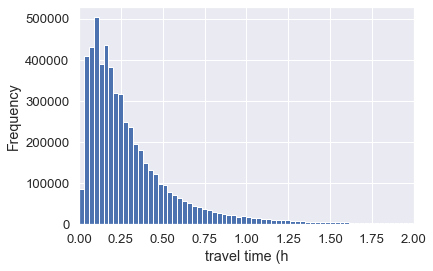

In [13]:
# fit survival function for travel time
#sns.histplot(data=inrix_trip_out, x="travel_time_h", bins=30)
inrix_trip_out['travel_time_h'].plot(kind = 'hist',bins = 500)
plt.xlabel('travel time (h')
plt.xlim([0, 2])

In [15]:
params = s.exponweib.fit(inrix_trip_out['travel_time_h'], floc=0, f0=1)
shape = params[1]
scale = params[3]
print('shape:', shape)
print('scale:',scale)

shape: 1.0724701436343587
scale: 0.34809723901244616


Text(0.5, 0, 'travel time (h)')

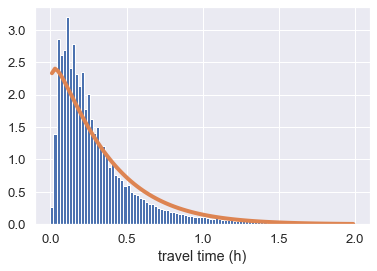

In [21]:
values,bins,hist = plt.hist(inrix_trip_out['travel_time_h'],bins=100, range=(0,2), density = True)
center = (bins[:-1] + bins[1:]) / 2.

# Using all params and the stats function
plt.plot(center,s.exponweib.pdf(center,*params),lw=4,label='scipy')
plt.xlabel('travel time (h)')